In [1]:
#pip install pmdarima

In [2]:
%matplotlib inline
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt
import datetime
import numpy as np
from datetime import datetime, timedelta


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [4]:
#Fetch only Finance Data
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("doge")
    print("Data transfer Done")
except BaseException as err:
    print(err)


Data transfer Done


In [5]:
df_dbFinanceData["date"] = pd.to_datetime(df_dbFinanceData["date"])
df_dbFinanceData.set_index("date", inplace=True)
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,id
date,,,,,,,,
2017-11-09,doge,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,5214
2017-11-10,doge,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,5215
2017-11-11,doge,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,5216
2017-11-12,doge,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,5217
2017-11-13,doge,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,5218
...,...,...,...,...,...,...,...,...
2022-07-09,doge,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
2022-07-10,doge,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
2022-07-11,doge,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919


In [6]:
df_dbFinanceData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1708 entries, 2017-11-09 to 2022-07-13
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   financeType    1708 non-null   object 
 1   open           1708 non-null   float64
 2   high           1708 non-null   float64
 3   low            1708 non-null   float64
 4   close          1708 non-null   float64
 5   adjustedClose  1708 non-null   float64
 6   volume         1708 non-null   int64  
 7   id             1708 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 120.1+ KB


<AxesSubplot:xlabel='date'>

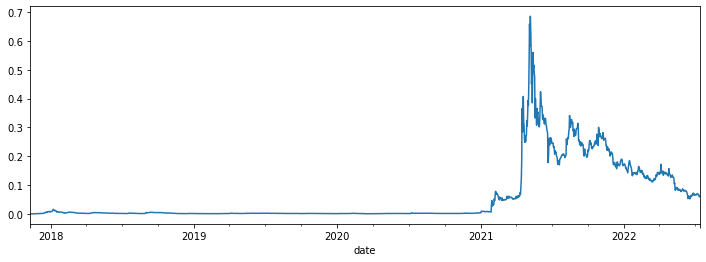

In [7]:
df_dbFinanceData['adjustedClose'].plot(figsize=(12,4))

In [8]:
df_dbFinanceData.index

DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07',
               '2022-07-08', '2022-07-09', '2022-07-10', '2022-07-11',
               '2022-07-12', '2022-07-13'],
              dtype='datetime64[ns]', name='date', length=1708, freq=None)

<AxesSubplot:xlabel='date'>

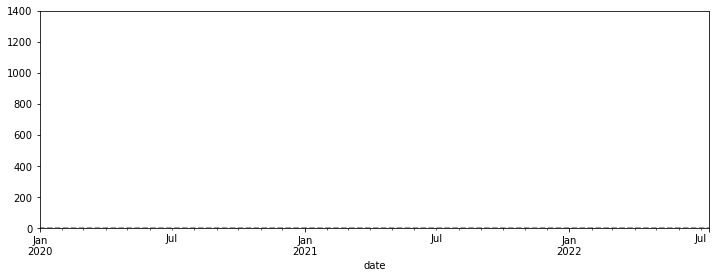

In [9]:
df_dbFinanceData['adjustedClose'].plot(xlim=['2020-01-01','2022-07-13'],ylim=[0,1400],figsize=(12,4),ls='--',c='green')

<AxesSubplot:xlabel='date'>

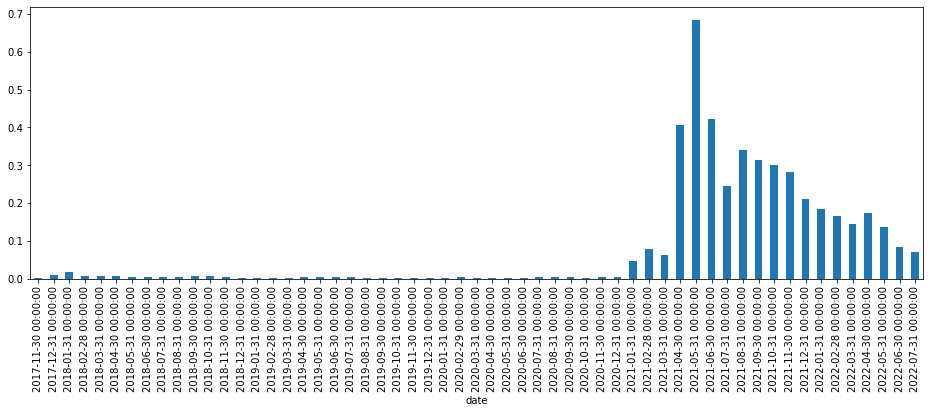

In [10]:
#Resampling to display monthly data
df_resampled = df_dbFinanceData['adjustedClose'].resample(rule='M')
df_resampled.max().plot(kind='bar',figsize=(16,5))

In [11]:
df_filteredData = df_dbFinanceData.loc['2020-01-01':'2022-7-13']
df_filteredData.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07',
               '2022-07-08', '2022-07-09', '2022-07-10', '2022-07-11',
               '2022-07-12', '2022-07-13'],
              dtype='datetime64[ns]', name='date', length=925, freq=None)

<AxesSubplot:xlabel='date'>

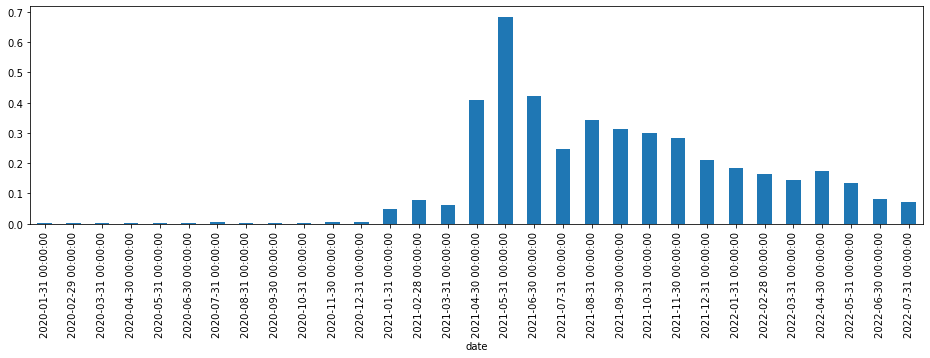

In [12]:
#Nov 2021 was the month when Tesla had highest value - checked over internet and found Nov 4 2021 was marked as highest price for Tesla stocks.
df_filteredData['adjustedClose'].resample(rule='M').max().plot(kind='bar', figsize=(16,4))

<AxesSubplot:xlabel='date'>

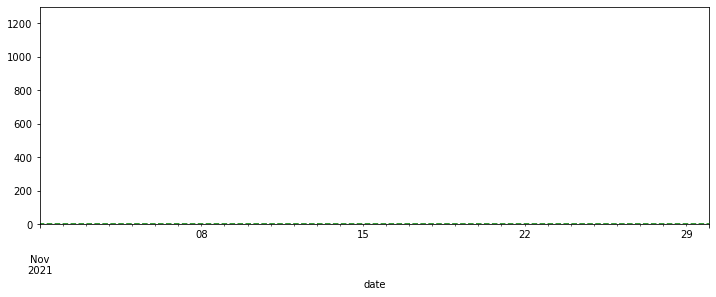

In [13]:
df_filteredData['adjustedClose'].plot(xlim=['2021-11-01','2021-11-30'],ylim=[0,1300],figsize=(12,4),ls='--',c='green')


<AxesSubplot:xlabel='date'>

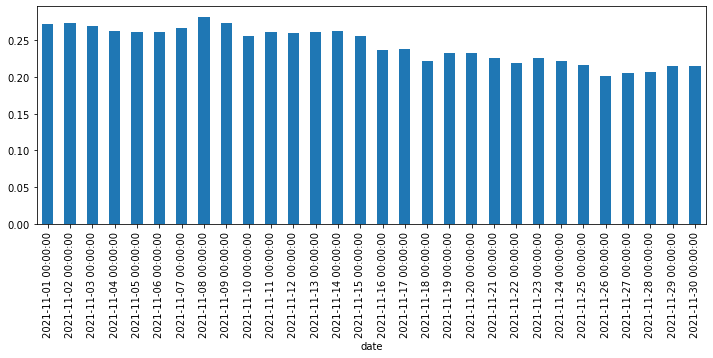

In [14]:
# checked over internet and found Nov 4 2021 was marked as highest price for Tesla stocks.
df_filteredData.loc['2021-11-01':'2021-11-30']['adjustedClose'].plot(kind='bar',figsize=(12,4))

In [15]:
#5 and 15 days rolling mean
df_dbFinanceData["adjustedClose:5 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(5).mean() 
df_dbFinanceData["adjustedClose:15 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(15).mean() 
df_dbFinanceData["adjustedClose:60 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(60).mean() 
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean
date,,,,,,,,,,,
2017-11-09,doge,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,5214,NaN,NaN,NaN
2017-11-10,doge,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,5215,NaN,NaN,NaN
2017-11-11,doge,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,5216,NaN,NaN,NaN
2017-11-12,doge,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,5217,NaN,NaN,NaN
2017-11-13,doge,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,5218,0.001206,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09,doge,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917,0.069026,0.068672,0.074572
2022-07-10,doge,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918,0.069047,0.068589,0.074284
2022-07-11,doge,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919,0.067700,0.067834,0.073937


<AxesSubplot:xlabel='date'>

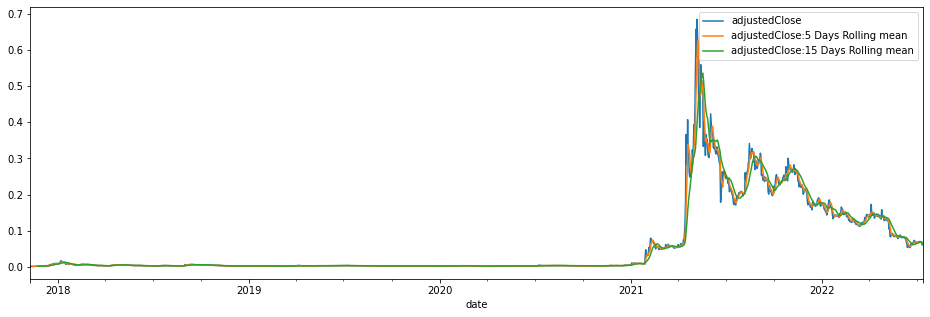

In [16]:
#smoothening the line
df_dbFinanceData[['adjustedClose','adjustedClose:5 Days Rolling mean','adjustedClose:15 Days Rolling mean']].plot(figsize=(16,5))

<AxesSubplot:xlabel='date'>

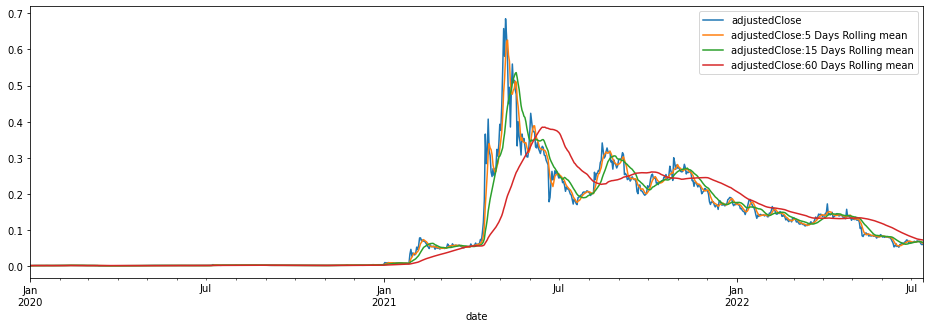

In [17]:
#smoothening the line
df_dbFinanceData.loc['2020-01-01':'2022-7-13'][['adjustedClose','adjustedClose:5 Days Rolling mean','adjustedClose:15 Days Rolling mean','adjustedClose:60 Days Rolling mean']].plot(figsize=(16,5))

#rolling mean of 5 days is closer compared to 15 days

<AxesSubplot:xlabel='date'>

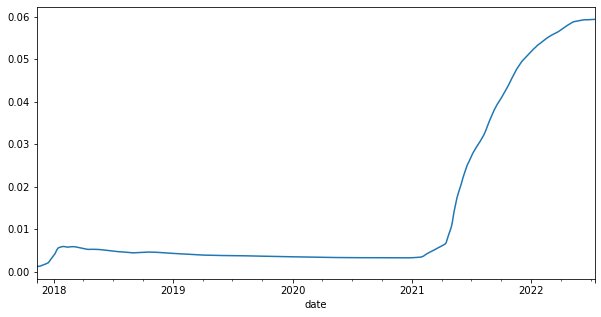

In [18]:
#Cummulative moving average
df_dbFinanceData['adjustedClose'].expanding().mean().plot(figsize=(10,5))

In [19]:
#exponential weighted moving average
df_dbFinanceData['emw0.2']=df_dbFinanceData['adjustedClose'].ewm(alpha=0.2,adjust=False).mean()
df_dbFinanceData['emw0.4']=df_dbFinanceData['adjustedClose'].ewm(alpha=0.4,adjust=False).mean()
df_dbFinanceData['emw_span5']=df_dbFinanceData['adjustedClose'].ewm(span=2,).mean()

<AxesSubplot:xlabel='date'>

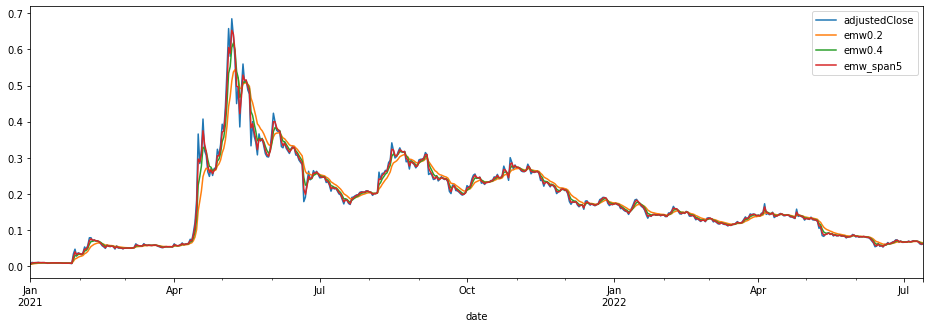

In [20]:
df_dbFinanceData[['adjustedClose','emw0.2','emw0.4','emw_span5']].plot(xlim=['2021-01-01','2022-7-13'],figsize=(16,5))

<AxesSubplot:xlabel='date'>

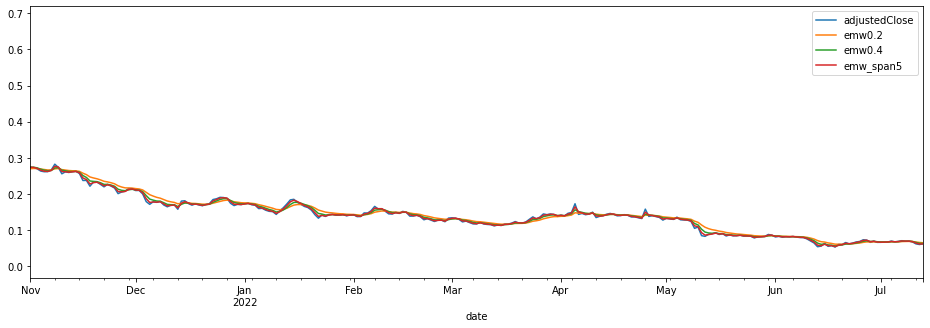

In [21]:
df_dbFinanceData[['adjustedClose','emw0.2','emw0.4','emw_span5']].plot(xlim=['2021-11-01','2022-7-13'],figsize=(16,5))

# Applying ARIMA Model

In [22]:
#Augmented Dickey–Fuller test
def adf_test(series):
    results = adfuller(series)
    print('ADF statistics: {}'.format(results[0]))
    print('P value: {}'.format(results[1]))
    if results[1] < 0.05:
        print("Ho Rejected - data is stationary")
    else:    
        print("Ho Accepted- data is not stationary")

In [23]:
adf_test(df_dbFinanceData['adjustedClose'])

ADF statistics: -2.4187282724682433
P value: 0.13652010989240332
Ho Accepted- data is not stationary


In [24]:
df_dbFinanceData['adjustedClose_first_diff']=df_dbFinanceData['adjustedClose']-df_dbFinanceData['adjustedClose'].shift(1)

In [25]:
adf_test(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#d=1

ADF statistics: -8.262922943789258
P value: 5.026682072867797e-13
Ho Rejected - data is stationary


In [26]:
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,,
2017-11-09,doge,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,5214,NaN,NaN,NaN,0.001415,0.001415,0.001415,NaN
2017-11-10,doge,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,5215,NaN,NaN,NaN,0.001365,0.001314,0.001226,-0.000252
2017-11-11,doge,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,5216,NaN,NaN,NaN,0.001332,0.001269,0.001209,0.000038
2017-11-12,doge,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,5217,NaN,NaN,NaN,0.001273,0.001177,0.001093,-0.000163
2017-11-13,doge,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,5218,0.001206,NaN,NaN,0.001261,0.001190,0.001172,0.000173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09,doge,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917,0.069026,0.068672,0.074572,0.068662,0.069292,0.069492,0.000255
2022-07-10,doge,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918,0.069047,0.068589,0.074284,0.068382,0.068480,0.068006,-0.002249
2022-07-11,doge,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919,0.067700,0.067834,0.073937,0.067075,0.065827,0.063900,-0.005416


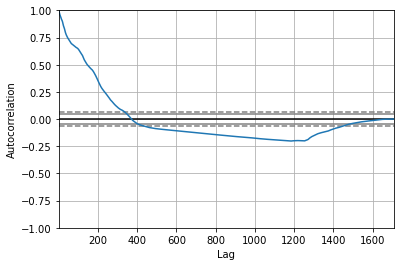

In [27]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_dbFinanceData['adjustedClose'])
plt.show()

# Calculate AR(p), I(d), MA(q) 

In [28]:
#Estimate ARIMA differencing term,
ndiffs(df_dbFinanceData['adjustedClose'],test='adf')

1

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


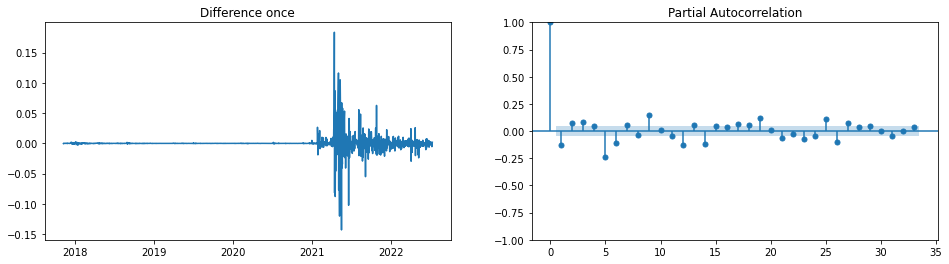

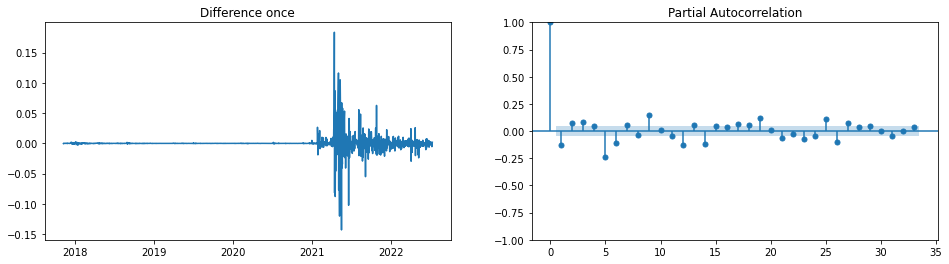

In [29]:
diff= df_dbFinanceData['adjustedClose'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)
#p=2

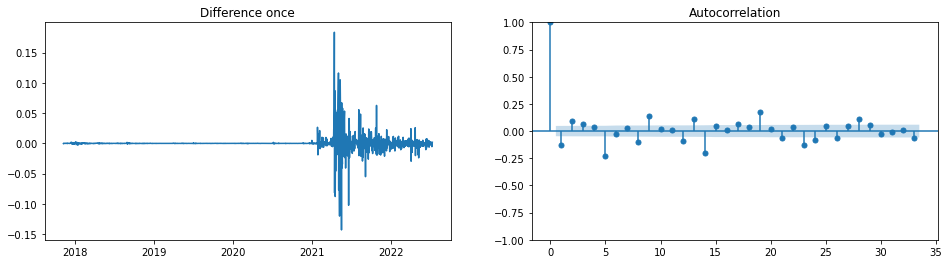

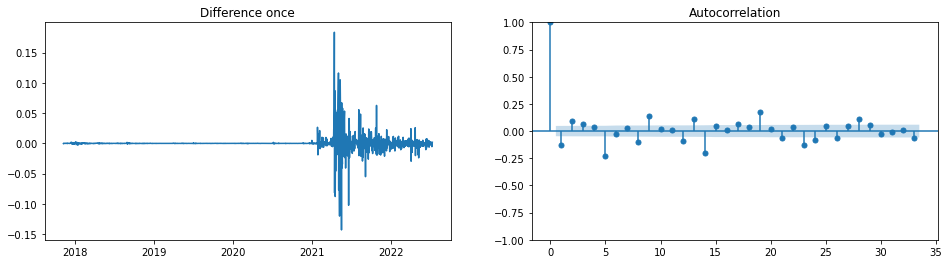

In [30]:
diff= df_dbFinanceData['adjustedClose'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)
#q=2

#Other ways to find P and Q

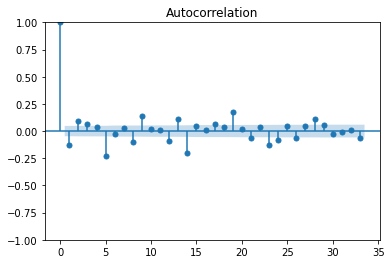

In [31]:
acf = plot_acf(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#q=2

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


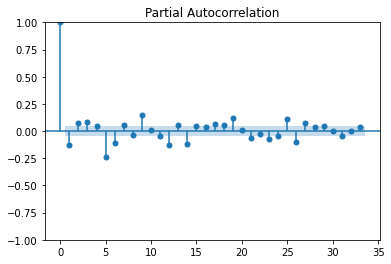

In [32]:
acf = plot_pacf(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#p=2

third way to find p,d,q- using Auto_arima

In [33]:
stepwise_fit = auto_arima(df_dbFinanceData['adjustedClose'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10143.691, Time=3.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10089.563, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10116.741, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10111.709, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10091.550, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10142.024, Time=2.99 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10123.208, Time=2.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-10180.729, Time=3.96 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-10132.767, Time=1.01 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-10176.249, Time=4.80 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-10205.297, Time=4.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-10185.604, Time=2.66 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-10201.692, Time=5.29 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-10206.622, Time=5.18 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1708
Model:               SARIMAX(5, 1, 4)   Log Likelihood                5168.234
Date:                Thu, 28 Jul 2022   AIC                         -10316.467
Time:                        19:58:08   BIC                         -10262.042
Sample:                             0   HQIC                        -10296.323
                               - 1708                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1968      0.019     10.286      0.000       0.159       0.234
ar.L2         -0.3223      0.021    -15.306      0.000      -0.364      -0.281
ar.L3          0.2725      0.018     15.539      0.000       0.238       0.307
ar.L4         -0.4879      0.014    -35.497      0.000      -0.515      -0.461
ar.L5         -0.2891      0.006    -48.186      0.000      -0.301      -0.277
ma.L1         -0.3339      0.020    -16.321      0.000      -0.374      -0.294
ma.L2          0.4672      0.024     19.725      0.000       0.421       0.514
ma.L3         -0.2544      0.020    -12.753      0.000      -0.294      -0.215
ma.L4          0.5833      0.016     36.296      0.000       0.552       0.615
sigma2         0.0001    9.5e-07    144.158      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):            337692.06
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):            1713.51   Skew:                             2.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        71.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Fitting the Model and Predicting

In [34]:
df_arima = df_dbFinanceData.copy()
df_arima.drop(columns=['financeType'],inplace=True)
train_dataset_end=datetime(2021,7,31)
test_dataset_end=datetime(2022,7,31)

In [35]:
train_data=df_arima[:train_dataset_end]
test_data=df_arima[train_dataset_end+timedelta(days=1):test_dataset_end]

In [36]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [37]:
train_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,5214,NaN,NaN,NaN,0.001415,0.001415,0.001415,NaN
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,5215,NaN,NaN,NaN,0.001365,0.001314,0.001226,-0.000252
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,5216,NaN,NaN,NaN,0.001332,0.001269,0.001209,0.000038
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,5217,NaN,NaN,NaN,0.001273,0.001177,0.001093,-0.000163
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,5218,0.001206,NaN,NaN,0.001261,0.001190,0.001172,0.000173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-27,0.203836,0.209293,0.195350,0.205899,0.205899,2229903212,6570,0.200053,0.189946,0.260664,0.196998,0.201501,0.204602,0.001480
2021-07-28,0.206111,0.213746,0.202011,0.205392,0.205392,2076707890,6571,0.202179,0.190305,0.259035,0.198677,0.203057,0.205129,-0.000507
2021-07-29,0.205591,0.206355,0.200716,0.204619,0.204619,1169322798,6572,0.203639,0.190792,0.257408,0.199865,0.203682,0.204789,-0.000773


In [38]:
test_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2021-08-01,0.207753,0.217611,0.201389,0.204437,0.204437,1711494501,6575,0.206317,0.196006,0.249113,0.203278,0.205836,0.205636,-0.003877
2021-08-02,0.204279,0.209959,0.202188,0.203600,0.203600,1181469976,6576,0.205958,0.197430,0.245841,0.203342,0.204941,0.204279,-0.000837
2021-08-03,0.203431,0.205077,0.193750,0.195967,0.195967,1121632377,6577,0.204228,0.198925,0.242835,0.201867,0.201352,0.198738,-0.007633
2021-08-04,0.196312,0.203110,0.194450,0.201490,0.201490,1095300718,6578,0.202762,0.200970,0.239990,0.201792,0.201407,0.200573,0.005523
2021-08-05,0.201575,0.202513,0.194685,0.200974,0.200974,1139204754,6579,0.201294,0.201679,0.237143,0.201628,0.201234,0.200840,-0.000516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917,0.069026,0.068672,0.074572,0.068662,0.069292,0.069492,0.000255
2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918,0.069047,0.068589,0.074284,0.068382,0.068480,0.068006,-0.002249
2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919,0.067700,0.067834,0.073937,0.067075,0.065827,0.063900,-0.005416


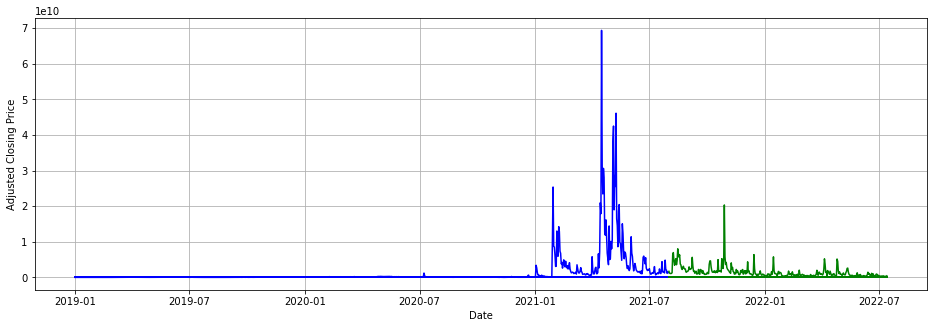

In [39]:
startdate=datetime(2019,1,1)
plt.figure(figsize=(16,5))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.plot(train_data[startdate:],'blue', label="training data")
plt.plot(test_data, 'green' , label="testing data")
#plt.legend(loc="upper left")

# Train the ARIMA Model

In [40]:
model_ARIMA=sm.tsa.arima.ARIMA(df_arima['adjustedClose'],order=(2,1,2))

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [41]:
model_ARIMA_fit = model_ARIMA.fit()

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [42]:
model_ARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          adjustedClose   No. Observations:                 1708
Model:                 ARIMA(2, 1, 2)   Log Likelihood                5077.841
Date:                Thu, 28 Jul 2022   AIC                         -10145.682
Time:                        19:58:10   BIC                         -10118.470
Sample:                    11-09-2017   HQIC                        -10135.610
                         - 07-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7828      0.009    -84.355      0.000      -0.801      -0.765
ar.L2         -0.9434      0.007   -128.188      0.000      -0.958      -0.929
ma.L1          0.7375      0.013     58.921      0.000       0.713       0.762
ma.L2          0.8795      0.010     91.479      0.000       0.861       0.898
sigma2         0.0002   8.98e-07    169.753      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                  11.44   Jarque-Bera (JB):            357576.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):            2570.52   Skew:                             1.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        73.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:ylabel='Density'>

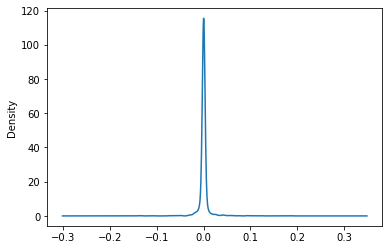

In [43]:
model_ARIMA_fit.resid.plot(kind='kde')

(array([5.39622156e-02, 1.79874052e-02, 1.61886647e-01, 1.25911836e+00,
        2.86179617e+01, 4.31697725e-01, 8.99370260e-02, 5.39622156e-02,
        1.79874052e-02, 1.79874052e-02]),
 array([-0.13911585, -0.1065664 , -0.07401695, -0.04146751, -0.00891806,
         0.02363139,  0.05618084,  0.08873028,  0.12127973,  0.15382918,
         0.18637862]),
 <BarContainer object of 10 artists>)

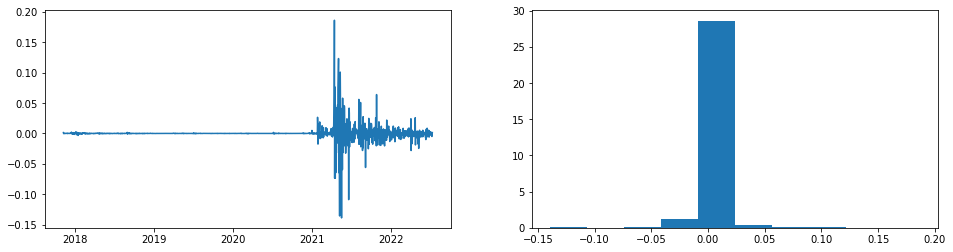

In [44]:
resids = pd.DataFrame(model_ARIMA_fit.resid)
fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,4))
ax1.plot(resids)
ax2.hist(resids, density=True)

In [45]:
##prediction
pred_start_date=pd.to_datetime(test_data.index[0])
pred_end_date=pd.to_datetime(test_data.index[-1])
print(pred_start_date)
print(pred_end_date)

2021-08-01 00:00:00
2022-07-13 00:00:00


In [46]:
-len(train_data)

-1361

Predicted Adjustclose Values
2021-08-01    0.207677
2021-08-02    0.205317
2021-08-03    0.203797
2021-08-04    0.195447
2021-08-05    0.201939
                ...   
2022-07-09    0.069535
2022-07-10    0.069805
2022-07-11    0.066888
2022-07-12    0.062255
2022-07-13    0.060542
Freq: D, Name: predicted_mean, Length: 347, dtype: float64


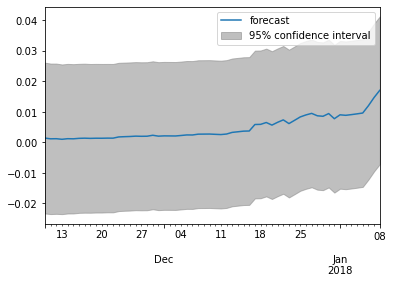

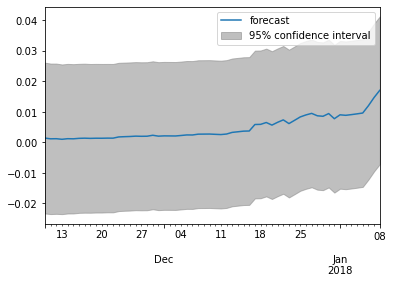

In [47]:
from statsmodels.graphics.tsaplots import plot_predict
adjustedCloseByArima_pred =model_ARIMA_fit.predict(start=len(train_data),end=(len(train_data) + len(test_data)-1)) 
adjustedCloseByArima_predictions = model_ARIMA_fit.get_prediction(start = -len(test_data))
residuals = test_data['adjustedClose']-adjustedCloseByArima_pred
print("Predicted Adjustclose Values")
print(adjustedCloseByArima_pred)
plot_predict(model_ARIMA_fit, start=1, end=60,dynamic=False)

In [48]:
df_yPred = adjustedCloseByArima_predictions.summary_frame(alpha=0.10)

# Extract prediction mean
mean_forecast = adjustedCloseByArima_predictions.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = adjustedCloseByArima_predictions.conf_int()
confidence_intervals


,lower adjustedClose,upper adjustedClose
2021-08-01,0.183474,0.231880
2021-08-02,0.181114,0.229521
2021-08-03,0.179594,0.228000
2021-08-04,0.171244,0.219650
2021-08-05,0.177736,0.226142
...,...,...
2022-07-09,0.045331,0.093738
2022-07-10,0.045602,0.094008
2022-07-11,0.042685,0.091091
2022-07-12,0.038052,0.086458


<AxesSubplot:>

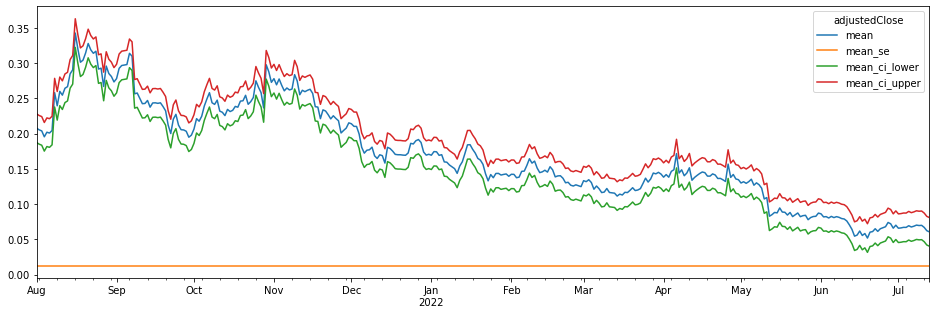

In [49]:
df_yPred.plot(figsize=(16,5))

In [50]:
d1 = pd.DataFrame(test_data['adjustedClose'])
d2 = pd.DataFrame(mean_forecast)
d2['date'] = d1.index
d2.set_index('date',inplace=True)
df_y_yPred = pd.concat([d1,d2],axis=1)

In [51]:
df_y_yPred

,adjustedClose,predicted_mean
date,,
2021-08-01,0.204437,0.207677
2021-08-02,0.203600,0.205317
2021-08-03,0.195967,0.203797
2021-08-04,0.201490,0.195447
2021-08-05,0.200974,0.201939
...,...,...
2022-07-09,0.069512,0.069535
2022-07-10,0.067263,0.069805
2022-07-11,0.061847,0.066888


<AxesSubplot:xlabel='date'>

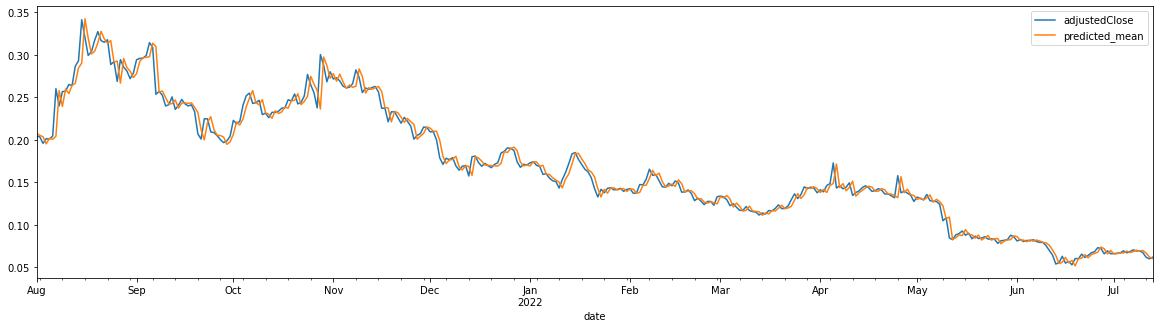

In [72]:
df_y_yPred.plot(figsize=(20,5))

# Forecasting

In [53]:
step = 30
fc = model_ARIMA_fit.forecast(step)
lst_fc = list(fc)
lst_fc

[0.061286763371433337,
 0.06128860676544398,
 0.06191571715825705,
 0.061423063106762675,
 0.061217082604326345,
 0.06184311729426181,
 0.06154737443831187,
 0.06118826265908983,
 0.06174839801562256,
 0.06164871249163784,
 0.06119829498135273,
 0.06164493826281805,
 0.06172023803407316,
 0.06123991125257574,
 0.06154488022218233,
 0.061759303125475784,
 0.06130372892592995,
 0.061458066913765375,
 0.0617670543052457,
 0.06137956418042805,
 0.06139138875255459,
 0.061747705425869444,
 0.061457617641243675,
 0.06134854137920341,
 0.06170760857353622,
 0.06152943015404495,
 0.06133015398968719,
 0.061654251894517405,
 0.06158854623596278,
 0.061334215461639696]

In [54]:
fc

2022-07-14    0.061287
2022-07-15    0.061289
2022-07-16    0.061916
2022-07-17    0.061423
2022-07-18    0.061217
2022-07-19    0.061843
2022-07-20    0.061547
2022-07-21    0.061188
2022-07-22    0.061748
2022-07-23    0.061649
2022-07-24    0.061198
2022-07-25    0.061645
2022-07-26    0.061720
2022-07-27    0.061240
2022-07-28    0.061545
2022-07-29    0.061759
2022-07-30    0.061304
2022-07-31    0.061458
2022-08-01    0.061767
2022-08-02    0.061380
2022-08-03    0.061391
2022-08-04    0.061748
2022-08-05    0.061458
2022-08-06    0.061349
2022-08-07    0.061708
2022-08-08    0.061529
2022-08-09    0.061330
2022-08-10    0.061654
2022-08-11    0.061589
2022-08-12    0.061334
Freq: D, Name: predicted_mean, dtype: float64

In [55]:
import time
import datetime
from datetime import date,timedelta


end_date = pred_end_date 

date_future = end_date + datetime.timedelta(41)

df_future_dates = pd.date_range(start=end_date, end=date_future,freq='B')
df_future_dates

DatetimeIndex(['2022-07-13', '2022-07-14', '2022-07-15', '2022-07-18',
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28',
               '2022-07-29', '2022-08-01', '2022-08-02', '2022-08-03',
               '2022-08-04', '2022-08-05', '2022-08-08', '2022-08-09',
               '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-15',
               '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19',
               '2022-08-22', '2022-08-23'],
              dtype='datetime64[ns]', freq='B')

In [56]:
df_future_dates

DatetimeIndex(['2022-07-13', '2022-07-14', '2022-07-15', '2022-07-18',
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28',
               '2022-07-29', '2022-08-01', '2022-08-02', '2022-08-03',
               '2022-08-04', '2022-08-05', '2022-08-08', '2022-08-09',
               '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-15',
               '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19',
               '2022-08-22', '2022-08-23'],
              dtype='datetime64[ns]', freq='B')

In [57]:
df_combine = pd.DataFrame(df_future_dates,lst_fc)
df_combine.columns=['date']
df_combine

,date
0.061287,2022-07-13
0.061289,2022-07-14
0.061916,2022-07-15
0.061423,2022-07-18
0.061217,2022-07-19
0.061843,2022-07-20
0.061547,2022-07-21
0.061188,2022-07-22
0.061748,2022-07-25
0.061649,2022-07-26


In [58]:
df_combine = df_combine.reset_index()
df_combine = df_combine.set_index('date')
df_combine

,index
date,
2022-07-13,0.061287
2022-07-14,0.061289
2022-07-15,0.061916
2022-07-18,0.061423
2022-07-19,0.061217
2022-07-20,0.061843
2022-07-21,0.061547
2022-07-22,0.061188
2022-07-25,0.061748


In [59]:
df_combine.rename(columns={"index":"forecasted_mean"},inplace=True)

In [60]:
df_combine

,forecasted_mean
date,
2022-07-13,0.061287
2022-07-14,0.061289
2022-07-15,0.061916
2022-07-18,0.061423
2022-07-19,0.061217
2022-07-20,0.061843
2022-07-21,0.061547
2022-07-22,0.061188
2022-07-25,0.061748


In [61]:
test_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2021-08-01,0.207753,0.217611,0.201389,0.204437,0.204437,1711494501,6575,0.206317,0.196006,0.249113,0.203278,0.205836,0.205636,-0.003877
2021-08-02,0.204279,0.209959,0.202188,0.203600,0.203600,1181469976,6576,0.205958,0.197430,0.245841,0.203342,0.204941,0.204279,-0.000837
2021-08-03,0.203431,0.205077,0.193750,0.195967,0.195967,1121632377,6577,0.204228,0.198925,0.242835,0.201867,0.201352,0.198738,-0.007633
2021-08-04,0.196312,0.203110,0.194450,0.201490,0.201490,1095300718,6578,0.202762,0.200970,0.239990,0.201792,0.201407,0.200573,0.005523
2021-08-05,0.201575,0.202513,0.194685,0.200974,0.200974,1139204754,6579,0.201294,0.201679,0.237143,0.201628,0.201234,0.200840,-0.000516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917,0.069026,0.068672,0.074572,0.068662,0.069292,0.069492,0.000255
2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918,0.069047,0.068589,0.074284,0.068382,0.068480,0.068006,-0.002249
2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919,0.067700,0.067834,0.073937,0.067075,0.065827,0.063900,-0.005416


In [62]:
test_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2021-08-01,0.207753,0.217611,0.201389,0.204437,0.204437,1711494501,6575,0.206317,0.196006,0.249113,0.203278,0.205836,0.205636,-0.003877
2021-08-02,0.204279,0.209959,0.202188,0.203600,0.203600,1181469976,6576,0.205958,0.197430,0.245841,0.203342,0.204941,0.204279,-0.000837
2021-08-03,0.203431,0.205077,0.193750,0.195967,0.195967,1121632377,6577,0.204228,0.198925,0.242835,0.201867,0.201352,0.198738,-0.007633
2021-08-04,0.196312,0.203110,0.194450,0.201490,0.201490,1095300718,6578,0.202762,0.200970,0.239990,0.201792,0.201407,0.200573,0.005523
2021-08-05,0.201575,0.202513,0.194685,0.200974,0.200974,1139204754,6579,0.201294,0.201679,0.237143,0.201628,0.201234,0.200840,-0.000516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917,0.069026,0.068672,0.074572,0.068662,0.069292,0.069492,0.000255
2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918,0.069047,0.068589,0.074284,0.068382,0.068480,0.068006,-0.002249
2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919,0.067700,0.067834,0.073937,0.067075,0.065827,0.063900,-0.005416


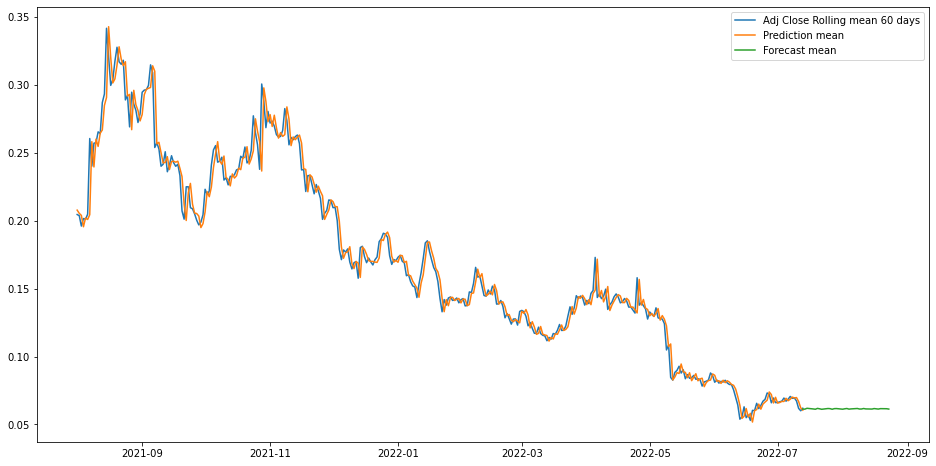

In [63]:
#plot the predictions for validation set
plt.figure(figsize=(16, 8))
plt.plot(test_data["adjustedClose"], label='Adj Close Rolling mean 60 days')
#plt.plot(valid, label='Valid')
plt.plot(df_y_yPred["predicted_mean"], label='Prediction mean')
plt.plot(df_combine["forecasted_mean"], label='Forecast mean')
plt.legend()
plt.show()

# MAE, RMSE, MAPE

In [64]:
from sklearn.metrics import mean_absolute_percentage_error
mape =mean_absolute_percentage_error(test_data["adjustedClose"],df_y_yPred["predicted_mean"])
mape
#MEAN ABSOLUTE PERCENTAGE ERROR (MAPE) = 29.7% is the difference between Actual vs Predicted

0.037424376634219755

In [65]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(test_data["adjustedClose"],df_y_yPred["predicted_mean"])
mae

0.006353115438923041

In [66]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_data["adjustedClose"],df_y_yPred["predicted_mean"]))
rmse 
#Root Mean Squared Error = 310 

0.01024899685860782

In [67]:
print("DOGE")
print("--------------")
print("MAE :" + str(mae) )
print("MAPE :" + str(mape) )
print("RMSE :" + str(rmse) )


DOGE
--------------
MAE :0.006353115438923041
MAPE :0.037424376634219755
RMSE :0.01024899685860782


# Scaled Value comparison

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
test_data_scaled = pd.DataFrame(scaler.fit_transform(pd.DataFrame(test_data["adjustedClose"])),columns=["adjustedClose"])

test_data_scaled.index = test_data.index


In [69]:
df_y_yPred_scaled = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df_y_yPred["predicted_mean"])),columns=["pred"])

df_y_yPred_scaled.index = df_y_yPred.index



In [70]:
df_forcast_scaled = pd.DataFrame(scaler.fit_transform(df_combine),columns=["forecast"])
df_forcast_scaled.index = df_combine.index

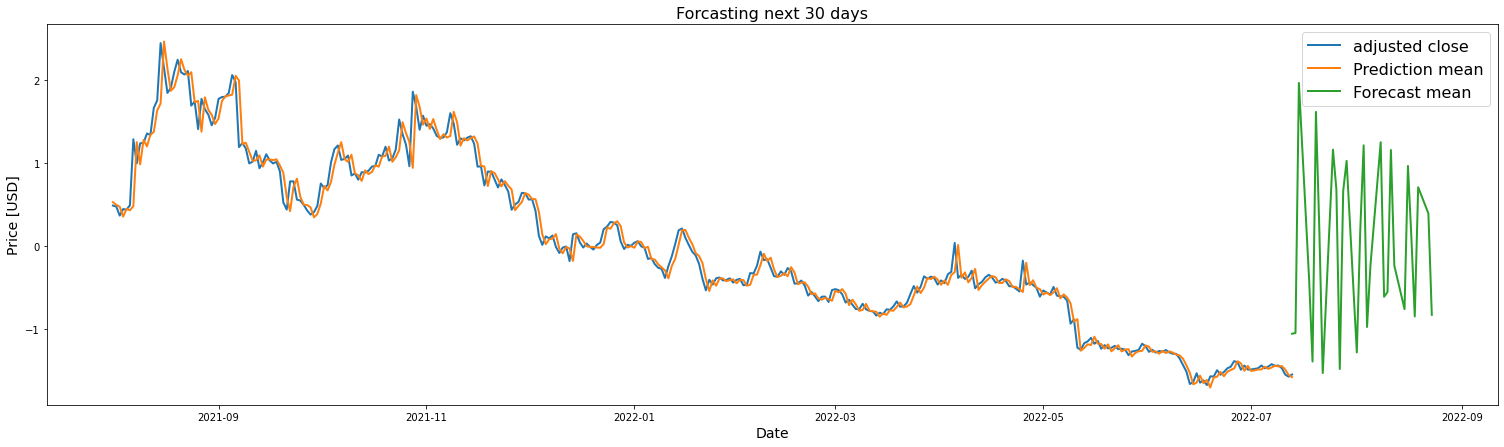

In [71]:
#plot the predictions for validation set
fig, ax = plt.subplots(1, figsize=(26, 7))
ax.plot(test_data_scaled, label='adjusted close', linewidth=2)
ax.plot(df_y_yPred_scaled, label= 'Prediction mean', linewidth=2)
ax.plot(df_forcast_scaled, label='Forecast mean', linewidth=2)
ax.set_ylabel('Price [USD]', fontsize=14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_title("Forcasting next 30 days", fontsize=16)
ax.legend(loc='best', fontsize=16)
